In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook
from nltk import word_tokenize
from nltk.corpus import sentiwordnet as swn
from string import punctuation
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
tqdm.pandas(tqdm_notebook)

D:\Anaconda\envs\project\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Sentiment analysis on the articles
This notebook implements a naive sentiment analysis on our dataset. Naive sentiment analysis employs the dictionary method to assign a sentiment to each word. By using the Sentiwordnet, it not only takes into account the actual word but also the word meaning. The cell below loads in our article dataset and also corrects the type of certain columns.

In [2]:
articles = pd.read_json('articles.json')
articles.publicationDay = pd.to_datetime(articles.publicationDay, unit='ms')
articles.publicationWeek = pd.to_datetime(articles.publicationWeek, unit='ms')

In the next cell we create a set of english stopwords and also a list of punctuation symbols. These combined list of words will be entirely ignored when calculating polarities. Each word will be ignored when using this list.

In [3]:
stopwords=set(stopwords.words('english')+list(punctuation))

In [4]:
def remove_words(article):
    article = word_tokenize(article)
    return [word for word in article if not word in stopwords]

In the next cell we create a function which we can give the text of an article. This function will look at each word in article. Each word will get a sentiment-score `weight` for each different meaning of the word in the dictonary. These weights are then averaged and added to the total article polarity `articlePolarity` which represents the cumulative averaged sentiment score of each word.

In [5]:
def naiveSentiment(article):
    articlePolarity = 0
    numExceptions = 0
    for word in article:
        word = word.lower()
        numMeanings = 0
        weight = 0.0
        try:
            for meaning in swn.senti_synsets(word):
                if meaning.pos_score() > meaning.neg_score():
                    weight += (meaning.pos_score() - meaning.neg_score())
                    numMeanings += 1
                elif meaning.pos_score() < meaning.neg_score():
                    weight -= (meaning.neg_score() - meaning.pos_score())
                    numMeanings += 1
        except:
            numExceptions += 1
        if numMeanings > 0:
            articlePolarity += (weight/numMeanings)
    return articlePolarity

## Sentiment analysis on full text

In [6]:
articles['filteredbodyText'] = articles.bodyText.progress_apply(remove_words)
articles['filteredwordcount'] = articles.filteredbodyText.apply(len)

100%|██████████████████████████████████████████████████████████████████████████████| 9172/9172 [01:39<00:00, 92.06it/s]


In [7]:
articles['articlePolarity'] = articles.filteredbodyText.progress_apply(naiveSentiment)

100%|██████████████████████████████████████████████████████████████████████████████| 9172/9172 [07:52<00:00, 19.40it/s]


In [8]:
articles.articlePolarity.describe()

count    9172.000000
mean       14.425379
std        26.711636
min       -39.307281
25%         5.161581
50%        10.097014
75%        16.349156
max       582.724918
Name: articlePolarity, dtype: float64

In [9]:
articles['articlePolarityNormalized'] = articles.articlePolarity / articles.filteredwordcount

In [10]:
articles.articlePolarityNormalized.describe()

count    9172.000000
mean        0.024517
std         0.016790
min        -0.055556
25%         0.013485
50%         0.024184
75%         0.035136
max         0.105938
Name: articlePolarityNormalized, dtype: float64

## Sentiment analysis on headlines

In [11]:
articles.headline = articles.headline.str.lower()
articles['headlineWordcount'] = articles.headline.apply(len) 

In [12]:
articles['headlinePolarity'] = articles.headline.progress_apply(naiveSentiment)

100%|█████████████████████████████████████████████████████████████████████████████| 9172/9172 [00:35<00:00, 261.18it/s]


In [13]:
articles.headlinePolarity.describe()

count    9172.000000
mean       -0.288637
std         1.116920
min        -5.375000
25%        -1.000000
50%        -0.375000
75%         0.500000
max         4.000000
Name: headlinePolarity, dtype: float64

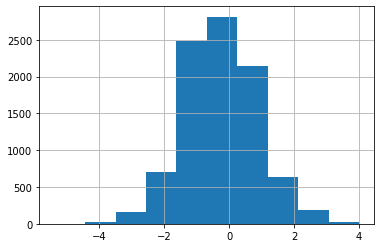

In [14]:
articles.headlinePolarity.hist()

## Visualisations

Text(0, 0.5, 'sentiment')

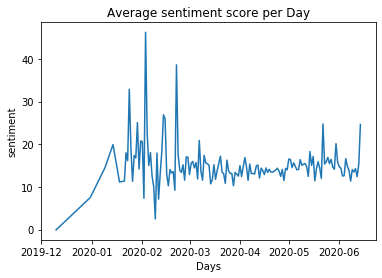

In [15]:
resp = articles.groupby('publicationDay').articlePolarity.mean()
plt.plot(resp)
plt.title('Average sentiment score per Day')
plt.xlabel('Days')
plt.ylabel('sentiment')

Text(0, 0.5, 'Sentiment')

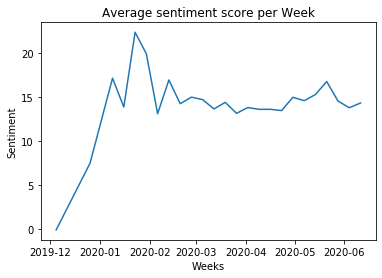

In [16]:
resp = articles.groupby('publicationWeek').articlePolarity.mean()
plt.plot(resp)
plt.title('Average sentiment score per Week')
plt.xlabel('Weeks')
plt.ylabel('Sentiment')

In [17]:
articles.to_json('articles_sentiment.json')